# Data

In [1]:
import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('../full_portfolio_analysis.ipynb'), '..'))
os.chdir(root_dir)
sys.path.insert(0, os.path.join(root_dir, 'src'))

In [2]:

from backbone.utils.wfo_utils import run_strategy, run_wfo
from backbone.utils.general_purpose import calculate_units_size, diff_pips

import itertools
import numpy as np
import pandas as pd
import pandas_ta as pandas_ta
import MetaTrader5 as mt5
import pandas as pd
from backtest.get_data import get_data
import pytz
from datetime import datetime
from pandas import Timestamp
import numpy as np
import random
from backtesting import Strategy
from backtesting.lib import crossover
import talib as ta

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

random.seed(42)

In [3]:
INITIAL_CASH = 10_000
MARGIN = 1/30

timezone = pytz.timezone("Etc/UTC")
date_from_get_data = datetime(2021, 10, 1, tzinfo=timezone)
date_to_get_data = datetime(2024, 9, 1, tzinfo=timezone)

#
limited_testing_start_date = Timestamp('2024-01-01 00:00:00', tz='UTC')
limited_testing_end_date = Timestamp('2024-10-01 00:00:00', tz='UTC')

In [4]:
groups = [
    'Forex',
    'Cash CFD',
    'Cash II CFD',
    'Metals CFD',
    'Crypto CFD',
    'Exotics',
    'Equities I CFD',
    'Equities II CFD',
    'Agriculture',
    'Commodities'
]

In [5]:
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

symbols = mt5.symbols_get()

tickers = [symbol.path.split('\\')[1] for symbol in symbols if (
    ('Agriculture' in symbol.path)
    or ('Cash CFD' in symbol.path)
    or ('Cash II CFD' in symbol.path)
    or ('Crypto CFD' in symbol.path)
    or ('Equities I CFD' in symbol.path)
    or ('Equities II CFD' in symbol.path)
    or ('Agriculture' in symbol.path)
    or ('Equities II CFD' in symbol.path)
    or ('Commodities' in symbol.path)
    or ('Forex' in symbol.path)
    )
]


print(tickers)

intervals = [
    # mt5.TIMEFRAME_H8,
    # mt5.TIMEFRAME_H6,
    mt5.TIMEFRAME_H4,
    mt5.TIMEFRAME_H3,
    mt5.TIMEFRAME_H2,
    mt5.TIMEFRAME_H1,
    # mt5.TIMEFRAME_M15,
    # mt5.TIMEFRAME_M10,
    # mt5.TIMEFRAME_M5,
]

symbols = get_data(tickers, intervals, date_from_get_data, date_to_get_data)

['EURUSD', 'GBPUSD', 'USDCHF', 'USDJPY', 'USDCAD', 'AUDUSD', 'AUDNZD', 'AUDCAD', 'AUDCHF', 'AUDJPY', 'CHFJPY', 'EURGBP', 'EURAUD', 'EURCHF', 'EURJPY', 'EURNZD', 'EURCAD', 'GBPCHF', 'GBPJPY', 'CADCHF', 'CADJPY', 'GBPAUD', 'GBPCAD', 'GBPNZD', 'NZDCAD', 'NZDCHF', 'NZDJPY', 'NZDUSD', 'GER40.cash', 'UK100.cash', 'US100.cash', 'US30.cash', 'US500.cash', 'AUS200.cash', 'EU50.cash', 'FRA40.cash', 'HK50.cash', 'JP225.cash', 'SPN35.cash', 'US2000.cash', 'N25.cash', 'UKOIL.cash', 'USOIL.cash', 'ADAUSD', 'BTCUSD', 'DASHUSD', 'DOGEUSD', 'DOTUSD', 'ETHUSD', 'LTCUSD', 'NEOUSD', 'XMRUSD', 'XRPUSD', 'AAPL', 'AMZN', 'BABA', 'BAC', 'GOOG', 'META', 'MSFT', 'NFLX', 'NVDA', 'PFE', 'RACE', 'T', 'TSLA', 'V', 'WMT', 'ZM', 'AIRF', 'ALVG', 'BAYGn', 'DBKGn', 'IBE', 'LVMH', 'VOWG_p', 'COCOA.c', 'COFFEE.c', 'CORN.c', 'SOYBEAN.c', 'WHEAT.c', 'NATGAS.cash']
MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4288
EURUSD
EURUSD
EURUSD
EURUSD
GBPUSD
GBPUSD
GBPUSD
GBPUSD
USDCHF
USDCHF
USDCHF
U

# Comisiones

In [6]:
commissions = {}

for ticker in tickers:
    symbol_info = mt5.symbol_info_tick(ticker)
    
    avg_price = (symbol_info.bid + symbol_info.ask) / 2
    spread = symbol_info.ask - symbol_info.bid
    
    commissions[ticker] = round(spread / avg_price, 5)
    
commissions

{'EURUSD': 2e-05,
 'GBPUSD': 7e-05,
 'USDCHF': 7e-05,
 'USDJPY': 4e-05,
 'USDCAD': 5e-05,
 'AUDUSD': 9e-05,
 'AUDNZD': 0.00013,
 'AUDCAD': 0.00014,
 'AUDCHF': 0.00017,
 'AUDJPY': 0.00013,
 'CHFJPY': 0.0001,
 'EURGBP': 0.00012,
 'EURAUD': 0.00011,
 'EURCHF': 0.00012,
 'EURJPY': 9e-05,
 'EURNZD': 0.00013,
 'EURCAD': 0.0001,
 'GBPCHF': 0.00015,
 'GBPJPY': 9e-05,
 'CADCHF': 0.00024,
 'CADJPY': 0.00014,
 'GBPAUD': 0.00015,
 'GBPCAD': 0.00011,
 'GBPNZD': 0.00012,
 'NZDCAD': 0.00021,
 'NZDCHF': 0.00031,
 'NZDJPY': 0.00017,
 'NZDUSD': 0.00015,
 'GER40.cash': 7e-05,
 'UK100.cash': 0.00014,
 'US100.cash': 0.0001,
 'US30.cash': 4e-05,
 'US500.cash': 0.00011,
 'AUS200.cash': 0.00017,
 'EU50.cash': 0.00035,
 'FRA40.cash': 0.00018,
 'HK50.cash': 0.00025,
 'JP225.cash': 0.00027,
 'SPN35.cash': 0.00053,
 'US2000.cash': 0.00045,
 'N25.cash': 0.00057,
 'UKOIL.cash': 0.00027,
 'USOIL.cash': 0.00046,
 'ADAUSD': 0.00429,
 'BTCUSD': 0.00034,
 'DASHUSD': 0.02546,
 'DOGEUSD': 0.00309,
 'DOTUSD': 0.00254,
 'ET

In [7]:
max_start_date = None
intervals_start_dates = {}

tickers = np.unique(list(symbols.keys())).tolist()

for interval in intervals:
    for ticker in tickers:
        if not max_start_date or symbols[ticker][interval].index.min() > max_start_date:
            max_start_date = symbols[ticker][interval].index.min()
        
    intervals_start_dates[interval] = max_start_date


print(intervals_start_dates)
print(limited_testing_start_date)
print(limited_testing_end_date)

{16388: Timestamp('2024-10-23 00:00:00+0000', tz='UTC'), 16387: Timestamp('2024-10-23 00:00:00+0000', tz='UTC'), 16386: Timestamp('2024-10-23 00:00:00+0000', tz='UTC'), 16385: Timestamp('2024-10-23 01:00:00+0000', tz='UTC')}
2024-01-01 00:00:00+00:00
2024-10-01 00:00:00+00:00


In [8]:
class Macd(Strategy):
    pip_value = None
    minimum_units = None
    maximum_units = None
    contract_volume = None
    opt_params = None
    
    risk=1
    atr_multiplier = 1.5
    sma_period = 200
    macd_fast_period = 7
    macd_slow_period = 26
    macd_signal_period = 9
    
    cum_rsi_open_threshold = 65
    cum_rsi_close_threshold = 45
    
    rsi_period = 2

    macd = pd.Series(dtype=float)
    macdsignal = pd.Series(dtype=float)
    macdhist = pd.Series(dtype=float)

    def init(self):
        self.sma = self.I(
            ta.SMA, self.data.Close, timeperiod=self.sma_period
        )
        
        self.atr = self.I(ta.ATR, self.data.High, self.data.Low, self.data.Close)
        self.rsi = self.I(ta.RSI, self.data.Close, timeperiod=self.rsi_period)
        
        
    def next(self):
        
        actual_date = self.data.index[-1]
        
        if self.opt_params and actual_date in self.opt_params.keys():
            for k, v in self.opt_params[actual_date].items():
                setattr(self, k, v)
        
            self.macd_slow_period = int(2.17 * self.macd_signal_period)
            self.macd_fast_period = int(1.33 * self.macd_signal_period)
                        
        self.macd, self.macdsignal, self.macdhist = ta.MACD(
            self.data.Close, 
            fastperiod=self.macd_fast_period, 
            slowperiod=self.macd_slow_period, 
            signalperiod=self.macd_signal_period
        )

        actual_close = self.data.Close[-1]
    
        if self.position:
            if self.position.is_long:
                if crossover(self.macd, self.macdsignal):
                    self.position.close()

            if self.position.is_short:
                if crossover(self.macdsignal, self.macd):
                    self.position.close()

        else:

            if crossover(self.macdsignal, self.macd) and actual_close > self.sma[-1]:        
                sl_price = self.data.Close[-1] - self.atr_multiplier * self.atr[-1]
                
                pip_distance = diff_pips(
                    self.data.Close[-1], 
                    sl_price, 
                    pip_value=self.pip_value
                )
                
                units = calculate_units_size(
                    account_size=self.equity, 
                    risk_percentage=self.risk, 
                    stop_loss_pips=pip_distance, 
                    pip_value=self.pip_value,
                    maximum_units=self.maximum_units,
                    minimum_units=self.minimum_units
                )
                
                self.buy(
                    size=units,
                    sl=sl_price
                )
                
            if crossover(self.macd, self.macdsignal) and actual_close < self.sma[-1]:
                sl_price = self.data.Close[-1] + self.atr_multiplier * self.atr[-1]
                
                pip_distance = diff_pips(
                    self.data.Close[-1], 
                    sl_price, 
                    pip_value=self.pip_value
                )
                
                units = calculate_units_size(
                    account_size=self.equity, 
                    risk_percentage=self.risk, 
                    stop_loss_pips=pip_distance, 
                    pip_value=self.pip_value,
                    maximum_units=self.maximum_units,
                    minimum_units=self.minimum_units
                )
                
                self.sell(
                    size=units,
                    sl=sl_price
                )
                
STRATEGY = Macd

# Analisis preliminar

In [9]:
strategies = [
    STRATEGY
]

experiments = list(itertools.product(
    tickers, intervals, strategies
))

stats_per_symbol = {}

performance = pd.DataFrame()

for ticker, interval, strategy in experiments:
    try:
        print(ticker, interval)
        
        commission = commissions[ticker]
        
        if ticker not in stats_per_symbol.keys():
            stats_per_symbol[ticker] = {}
        
        prices = symbols[ticker][interval].loc[limited_testing_start_date:limited_testing_end_date]

        df_stats, stats = run_strategy(
            strategy=strategy,
            ticker=ticker,
            interval=interval,
            commission=commission, 
            prices=prices, 
            initial_cash=INITIAL_CASH, 
            margin=MARGIN
        )

        performance = pd.concat([performance, df_stats])
        stats_per_symbol[ticker][interval] = stats

    except Exception as e:
        print(f'hubo un problema con {ticker} {interval}: {e}')


performance['return/dd'] = performance['return'] / -performance['drawdown']
performance['drawdown'] = -performance['drawdown']
performance['custom_metric'] = (performance['return'] / (1 + performance.drawdown)) * np.log(1 + performance.trades)

AAPL 16388
AAPL 16387
AAPL 16386
AAPL 16385
ADAUSD 16388
ADAUSD 16387
ADAUSD 16386
ADAUSD 16385
AIRF 16388
AIRF 16387
AIRF 16386
AIRF 16385
ALVG 16388
ALVG 16387
ALVG 16386
ALVG 16385
AMZN 16388
AMZN 16387
AMZN 16386
AMZN 16385
AUDCAD 16388
AUDCAD 16387
AUDCAD 16386
AUDCAD 16385
AUDCHF 16388
AUDCHF 16387
AUDCHF 16386
AUDCHF 16385
AUDJPY 16388
AUDJPY 16387
AUDJPY 16386
AUDJPY 16385
AUDNZD 16388
AUDNZD 16387
AUDNZD 16386
AUDNZD 16385
AUDUSD 16388
AUDUSD 16387
AUDUSD 16386
AUDUSD 16385
AUS200.cash 16388
AUS200.cash 16387
AUS200.cash 16386
AUS200.cash 16385
BABA 16388
BABA 16387
BABA 16386
BABA 16385
BAC 16388
BAC 16387
BAC 16386
BAC 16385
BAYGn 16388
BAYGn 16387
BAYGn 16386
BAYGn 16385
BTCUSD 16388
BTCUSD 16387
BTCUSD 16386
BTCUSD 16385
CADCHF 16388
CADCHF 16387
CADCHF 16386
CADCHF 16385
CADJPY 16388
CADJPY 16387
CADJPY 16386
CADJPY 16385
CHFJPY 16388
CHFJPY 16387
CHFJPY 16386
CHFJPY 16385
COCOA.c 16388
COCOA.c 16387
COCOA.c 16386
COCOA.c 16385


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(
c:\Users\S

COFFEE.c 16388
COFFEE.c 16387
COFFEE.c 16386
COFFEE.c 16385
CORN.c 16388
CORN.c 16387
CORN.c 16386
CORN.c 16385
DASHUSD 16388
DASHUSD 16387
DASHUSD 16386
DASHUSD 16385
DBKGn 16388
DBKGn 16387
DBKGn 16386
DBKGn 16385
DOGEUSD 16388
DOGEUSD 16387
DOGEUSD 16386
DOGEUSD 16385
DOTUSD 16388
DOTUSD 16387
DOTUSD 16386
DOTUSD 16385
ETHUSD 16388
ETHUSD 16387
ETHUSD 16386
ETHUSD 16385
EU50.cash 16388
EU50.cash 16387
EU50.cash 16386
EU50.cash 16385
EURAUD 16388
EURAUD 16387
EURAUD 16386
EURAUD 16385
EURCAD 16388
EURCAD 16387
EURCAD 16386
EURCAD 16385
EURCHF 16388
EURCHF 16387
EURCHF 16386
EURCHF 16385
EURGBP 16388
EURGBP 16387
EURGBP 16386
EURGBP 16385
EURJPY 16388
EURJPY 16387
EURJPY 16386
EURJPY 16385
EURNZD 16388
EURNZD 16387
EURNZD 16386
EURNZD 16385
EURUSD 16388
EURUSD 16387
EURUSD 16386
EURUSD 16385
FRA40.cash 16388
FRA40.cash 16387
FRA40.cash 16386
FRA40.cash 16385
GBPAUD 16388
GBPAUD 16387
GBPAUD 16386
GBPAUD 16385
GBPCAD 16388
GBPCAD 16387
GBPCAD 16386
GBPCAD 16385
GBPCHF 16388
GBPCHF 1638

In [10]:

rob_test = performance.groupby(['strategy', 'ticker']).agg({
    'return/dd': ['mean', 'std'],
    'stability_ratio': ['mean', 'std'],
    'trades': ['mean', 'std']
})

rob_test['return_dd_mean_std'] = rob_test[('return/dd', 'mean')] / rob_test[('return/dd', 'std')]


rob_test = rob_test[(rob_test[('return/dd', 'mean')] >= 1) & (rob_test[('trades', 'mean')] > 10)].sort_values(by='return_dd_mean_std', ascending=False)

display(rob_test)

average_positive_tickers = rob_test.reset_index().ticker.tolist()

filter_performance = performance[performance['ticker'].isin(average_positive_tickers)]

portfolio = filter_performance.ticker.values.tolist()

intervals = filter_performance.interval.values.tolist()

filter_performance = filter_performance.sort_values(by=['ticker', 'interval'], ascending=[True, True])[
    [
        'strategy',
        'ticker',
        'interval',
        'stability_ratio',
        'trades',
        'return',
        'drawdown',
        'return/dd',
        'custom_metric',
        'win_rate',
        'avg_trade_percent',
        'Duration'
        ]
]#.drop_duplicates(subset=['ticker'], keep='first')

display(filter_performance.head(50))

return/dd           stability_ratio           trades  \
                         mean       std            mean       std   mean   
strategy ticker                                                            
Macd     AAPL        1.189428  0.872361        0.374482  0.357978  24.00   
         LVMH        1.903689  1.929432        0.756591  0.120582  31.75   
         SPN35.cash  1.031149  2.116390        0.723781  0.186100  44.25   

                               return_dd_mean_std  
                           std                     
strategy ticker                                    
Macd     AAPL        17.832555           1.363459  
         LVMH        20.105969           0.986657  
         SPN35.cash  28.111386           0.487221

,strategy,ticker,interval,stability_ratio,trades,return,drawdown,return/dd,custom_metric,win_rate,avg_trade_percent,Duration
0,Macd,AAPL,16385,0.717291,49,11.061104,5.353102,2.066298,6.811050,57.142857,0.164740,241 days 06:00:00
0,Macd,AAPL,16386,0.641509,22,5.118405,2.888844,1.771783,4.126864,54.545455,0.201345,241 days 06:00:00
0,Macd,AAPL,16387,0.000019,18,1.900285,2.735452,0.694688,1.497884,55.555556,0.096009,241 days 06:00:00
0,Macd,AAPL,16388,0.139109,7,0.537402,2.389067,0.224942,0.329736,42.857143,0.052735,241 days 04:00:00
0,Macd,LVMH,16385,0.603427,60,-12.319821,19.275767,-0.639135,-2.497821,40.000000,-0.249369,241 days 08:00:00
0,Macd,LVMH,16386,0.898348,30,15.614422,3.857648,4.047653,11.038207,60.000000,0.583143,241 days 08:00:00
0,Macd,LVMH,16387,0.761695,24,6.589466,3.312954,1.989000,4.917899,58.333333,0.335157,241 days 09:00:00
0,Macd,LVMH,16388,0.762893,13,6.025563,2.717600,2.217237,4.277439,69.230769,0.648299,241 days 08:00:00
0,Macd,SPN35.cash,16385,0.893573,83,-20.359563,25.700735,-0.792178,-3.378540,39.759036,-0.139144,241 days 11:00:00
0,Macd,SPN35.cash,16386,0.673325,47,-6.847366,17.680041,-0.387294,-1.419029,42.553191,-0.150369,241 days 12:00:00


In [11]:
for ticker, interval in zip(portfolio, intervals):
    
    prices = symbols[ticker][interval].loc[limited_testing_start_date:limited_testing_end_date]
    commission = commissions[ticker]

    df_stats = run_strategy(
        strategy=strategy,
        ticker=ticker,
        interval=interval,
        commission=commission, 
        prices=prices, 
        initial_cash=INITIAL_CASH, 
        margin=MARGIN,
        plot=True
    )
    break
    

c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


# WFO

In [12]:
lookback_bars_per_interval = {
    5: 3000,
    10: 2500,
    15: 2000,
    16385: 2000,
    16386: 1800,
    16387: 1800,
    16388: 1200,
    16390: 1200,
    16392: 1200,
}

In [13]:
from backbone.utils.wfo_utils import optimization_function

validation_bars = 200
warmup_bars =  200

all_wfo_performances = pd.DataFrame()
all_opt_params = {}

params = {
    'macd_signal_period' : [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
}

for index, row in filter_performance.iterrows():
    
    try:
        ticker = row.ticker
        interval = row.interval
        commission = commissions[ticker]
        print(ticker, interval)
        
        lookback_bars = lookback_bars_per_interval[interval]
        
        prices = symbols[ticker][interval]

        wfo_stats, df_stats, opt_params = run_wfo(
            strategy=STRATEGY,
            ticker=ticker,
            interval=interval,
            prices=prices,
            initial_cash=INITIAL_CASH,
            commission=commission,
            margin=MARGIN,
            optim_func=optimization_function,
            params=params,
            lookback_bars=lookback_bars,
            warmup_bars=warmup_bars,
            validation_bars=validation_bars,
            plot=False
        )
                
        if ticker not in all_opt_params.keys():
            all_opt_params[ticker] = {}

        all_opt_params[ticker][interval] = opt_params

        all_wfo_performances = pd.concat([all_wfo_performances, df_stats])
        
    
    except Exception as e:
        print(f'No se pudo ejecutar para el ticker {ticker}: {e}')
    
all_wfo_performances['return/dd'] = all_wfo_performances['return'] / -all_wfo_performances['drawdown']
all_wfo_performances['drawdown'] = -all_wfo_performances['drawdown']
all_wfo_performances['custom_metric'] = (all_wfo_performances['return'] / (1 + all_wfo_performances.drawdown)) * np.log(1 + all_wfo_performances.trades)

all_wfo_performances.drawdown_duration = pd.to_timedelta(all_wfo_performances.drawdown_duration)
all_wfo_performances.drawdown_duration = all_wfo_performances.drawdown_duration.dt.days

AAPL 16385
AAPL 16386
AAPL 16387
AAPL 16388
LVMH 16385
LVMH 16386
LVMH 16387
LVMH 16388
SPN35.cash 16385
SPN35.cash 16386
SPN35.cash 16387
SPN35.cash 16388


In [14]:

performance = pd.DataFrame()

wfo_stats_per_symbol = {}

for index, row in filter_performance.iterrows():
    try:
        
        ticker = row.ticker
        interval = row.interval
        commission = commissions[ticker]
        print(ticker, interval)
        
        params = all_opt_params[ticker][interval]
        prices = symbols[ticker][interval].iloc[lookback_bars - warmup_bars + 1:]
        
        if ticker not in wfo_stats_per_symbol.keys():
            wfo_stats_per_symbol[ticker] = {}

        df_stats, wfo_stats = run_strategy(
            strategy=STRATEGY,
            ticker=ticker,
            interval=interval,
            commission=commission, 
            prices=prices, 
            initial_cash=INITIAL_CASH, 
            margin=MARGIN, 
            opt_params=params, 
            plot=True
        )

        wfo_stats_per_symbol[ticker][interval] = wfo_stats

        performance = pd.concat([performance, df_stats])

    except Exception as e:
        print(f'hubo un problema con {ticker} {interval}: {e}')


performance['return/dd'] = performance['return'] / -performance['drawdown']
performance['drawdown'] = -performance['drawdown']
performance['custom_metric'] = (performance['return'] / (1 + performance.drawdown)) * np.log(1 + performance.trades)

AAPL 16385


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


AAPL 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


AAPL 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


AAPL 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


LVMH 16385


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


LVMH 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


LVMH 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


LVMH 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


SPN35.cash 16385


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


SPN35.cash 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


SPN35.cash 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


SPN35.cash 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


In [21]:

rob_test = performance.groupby(['strategy', 'ticker']).agg({
    'return/dd': ['mean', 'std'],
    'stability_ratio': ['mean', 'std'],
    'trades': ['mean', 'std']
})

rob_test['return_dd_mean_std'] = rob_test[('return/dd', 'mean')] / rob_test[('return/dd', 'std')]

rob_test = rob_test[(rob_test[('return/dd', 'mean')] > 0) & (rob_test[('trades', 'mean')] > 10)].sort_values(by='return_dd_mean_std', ascending=False)

display(rob_test)

average_positive_tickers = rob_test.reset_index().ticker.tolist()

filter_performance = performance[performance['ticker'].isin(average_positive_tickers)]

portfolio = filter_performance.ticker.values.tolist()

intervals = filter_performance.interval.values.tolist()

filter_performance = filter_performance.sort_values(by=['ticker', 'interval'], ascending=[True, True])[
    [
        'strategy',
        'ticker',
        'interval',
        'stability_ratio',
        'trades',
        'return',
        'drawdown',
        'return/dd',
        'custom_metric',
        'win_rate',
        'avg_trade_percent',
        'Duration'
        ]
]#.drop_duplicates(subset=['ticker'], keep='first')

display(filter_performance.head(50))

return/dd           stability_ratio            trades  \
                     mean       std            mean       std    mean   
strategy ticker                                                         
Macd     LVMH    0.532546  2.271586        0.669055  0.208089  100.25   

                           return_dd_mean_std  
                       std                     
strategy ticker                                
Macd     LVMH    74.141194           0.234438

,strategy,ticker,interval,stability_ratio,trades,return,drawdown,return/dd,custom_metric,win_rate,avg_trade_percent,Duration
0,Macd,LVMH,16385,0.831276,208,-19.883537,27.406270,-0.725511,-3.739474,43.269231,-0.104483,906 days 05:00:00
0,Macd,LVMH,16386,0.798285,89,26.029813,6.614226,3.935428,15.382942,48.314607,0.339557,779 days 08:00:00
0,Macd,LVMH,16387,0.672353,59,-6.073863,13.637742,-0.445372,-1.698929,32.203390,-0.131839,709 days 03:00:00
0,Macd,LVMH,16388,0.374306,45,-4.612414,7.270941,-0.634363,-2.135099,42.222222,-0.116830,591 days 04:00:00


In [22]:
filtered_wfo_performance = performance[
    (
        ((performance['ticker'] == 'LVMH') & (performance['interval'] == 16386))
    )
].sort_values(by='custom_metric', ascending=False).drop_duplicates(subset=['ticker'], keep='first')

filtered_wfo_performance

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,Macd,LVMH,16386,0.798285,26.029813,12602.981296,6.614226,246 days 04:00:00,48.314607,1.048226,89,0.339557,29.220066,12602.981296,779 days 08:00:00,3.935428,15.382942


# Montecarlo

In [23]:
# Crear una lista para almacenar los resultados de cada ticker
from backbone.utils.montecarlo_utils import montecarlo_statistics_simulation

data_drawdown = []
data_return = []
montecarlo_simulations = {}

all_drawdowns = pd.DataFrame()
all_returns = pd.DataFrame()

for index, row in filtered_wfo_performance.iterrows():
    ticker = row.ticker
    interval = row.interval
    try:
        
        print(f"Procesando ticker: {ticker} {interval}")
        trades_history = wfo_stats_per_symbol[ticker][interval]._trades
        eq_curve = wfo_stats_per_symbol[ticker][interval]._equity_curve
        
        # Simulación de Montecarlo para cada ticker (datos agregados)
        mc, synthetic_drawdown_curve, synthetic_return_curve = montecarlo_statistics_simulation(
            equity_curve=eq_curve,
            trade_history=trades_history, 
            n_simulations=100_000, 
            initial_equity=INITIAL_CASH, 
            threshold_ruin=0.9, 
            return_raw_curves=True,
            percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]
        )
        
        montecarlo_simulations[f"{ticker}_{interval}"] = mc
        
        synthetic_drawdown_curve["ticker"] = f"{ticker}_{interval}"
        synthetic_return_curve["ticker"] = f"{ticker}_{interval}"
        
        all_drawdowns = pd.concat([all_drawdowns, synthetic_drawdown_curve])
        all_returns = pd.concat([all_returns, synthetic_return_curve])
    
    except Exception as e:
        print(f'hubo un problema con {ticker}_{interval}: {e}')

Procesando ticker: LVMH 16386


In [24]:
dd_df = pd.DataFrame()
returns_df = pd.DataFrame()

for ticker, mc in montecarlo_simulations.items():
    mc = mc.rename(
        columns={
            'Drawdown (%)': f'drawdown_{ticker}',
            'Final Return (%)': f'return_{ticker}',
        }
    )

    if dd_df.empty:
        dd_df = mc[[f'drawdown_{ticker}']]
    
    else:
        dd_df = pd.merge(
            dd_df,
            mc[[f'drawdown_{ticker}']],
            left_index=True,
            right_index=True            
        )
        
    if returns_df.empty:
        returns_df = mc[[f'return_{ticker}']]
    
    else:
        returns_df = pd.merge(
            returns_df,
            mc[[f'return_{ticker}']],
            left_index=True,
            right_index=True            
        )
        
display(dd_df)
display(returns_df)


,drawdown_LVMH_16386
count,100000.000000
mean,-9.733200
std,3.906440
min,-40.379778
10%,-14.936578
25%,-11.723397
50%,-8.952770
75%,-6.922044
90%,-5.555754
max,-1.883346


,return_LVMH_16386
count,100000.000000
mean,25.709509
std,18.712851
min,-36.409695
10%,2.891123
25%,12.506018
50%,24.413095
75%,37.379524
90%,50.183818
max,148.283440


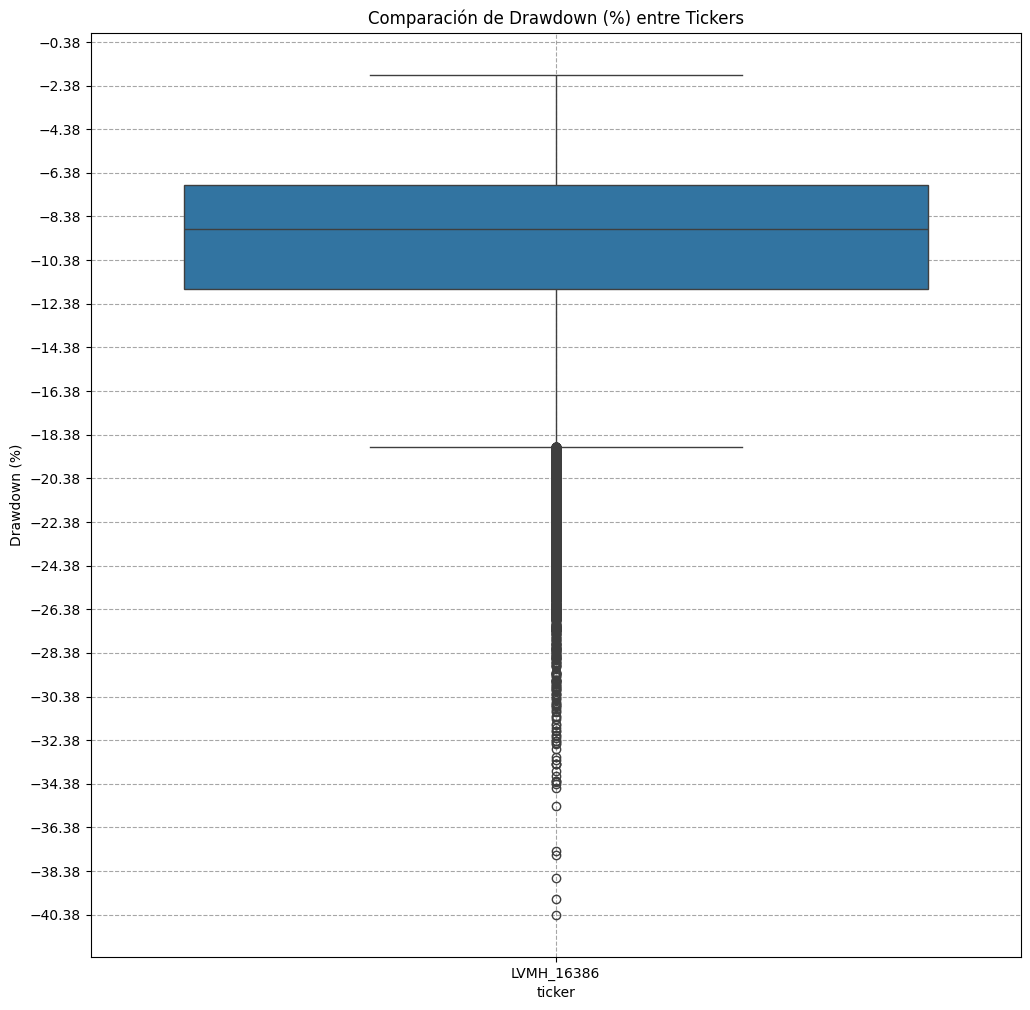

In [25]:
# Configurar el gráfico con matplotlib y seaborn
plt.figure(figsize=(12, 12))
sns.boxplot(data=all_drawdowns, x="ticker", y="Drawdown (%)")
plt.title("Comparación de Drawdown (%) entre Tickers")

y_max = all_drawdowns["Drawdown (%)"].max()  # Valor máximo en el eje Y
y_min = all_drawdowns["Drawdown (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 2  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()


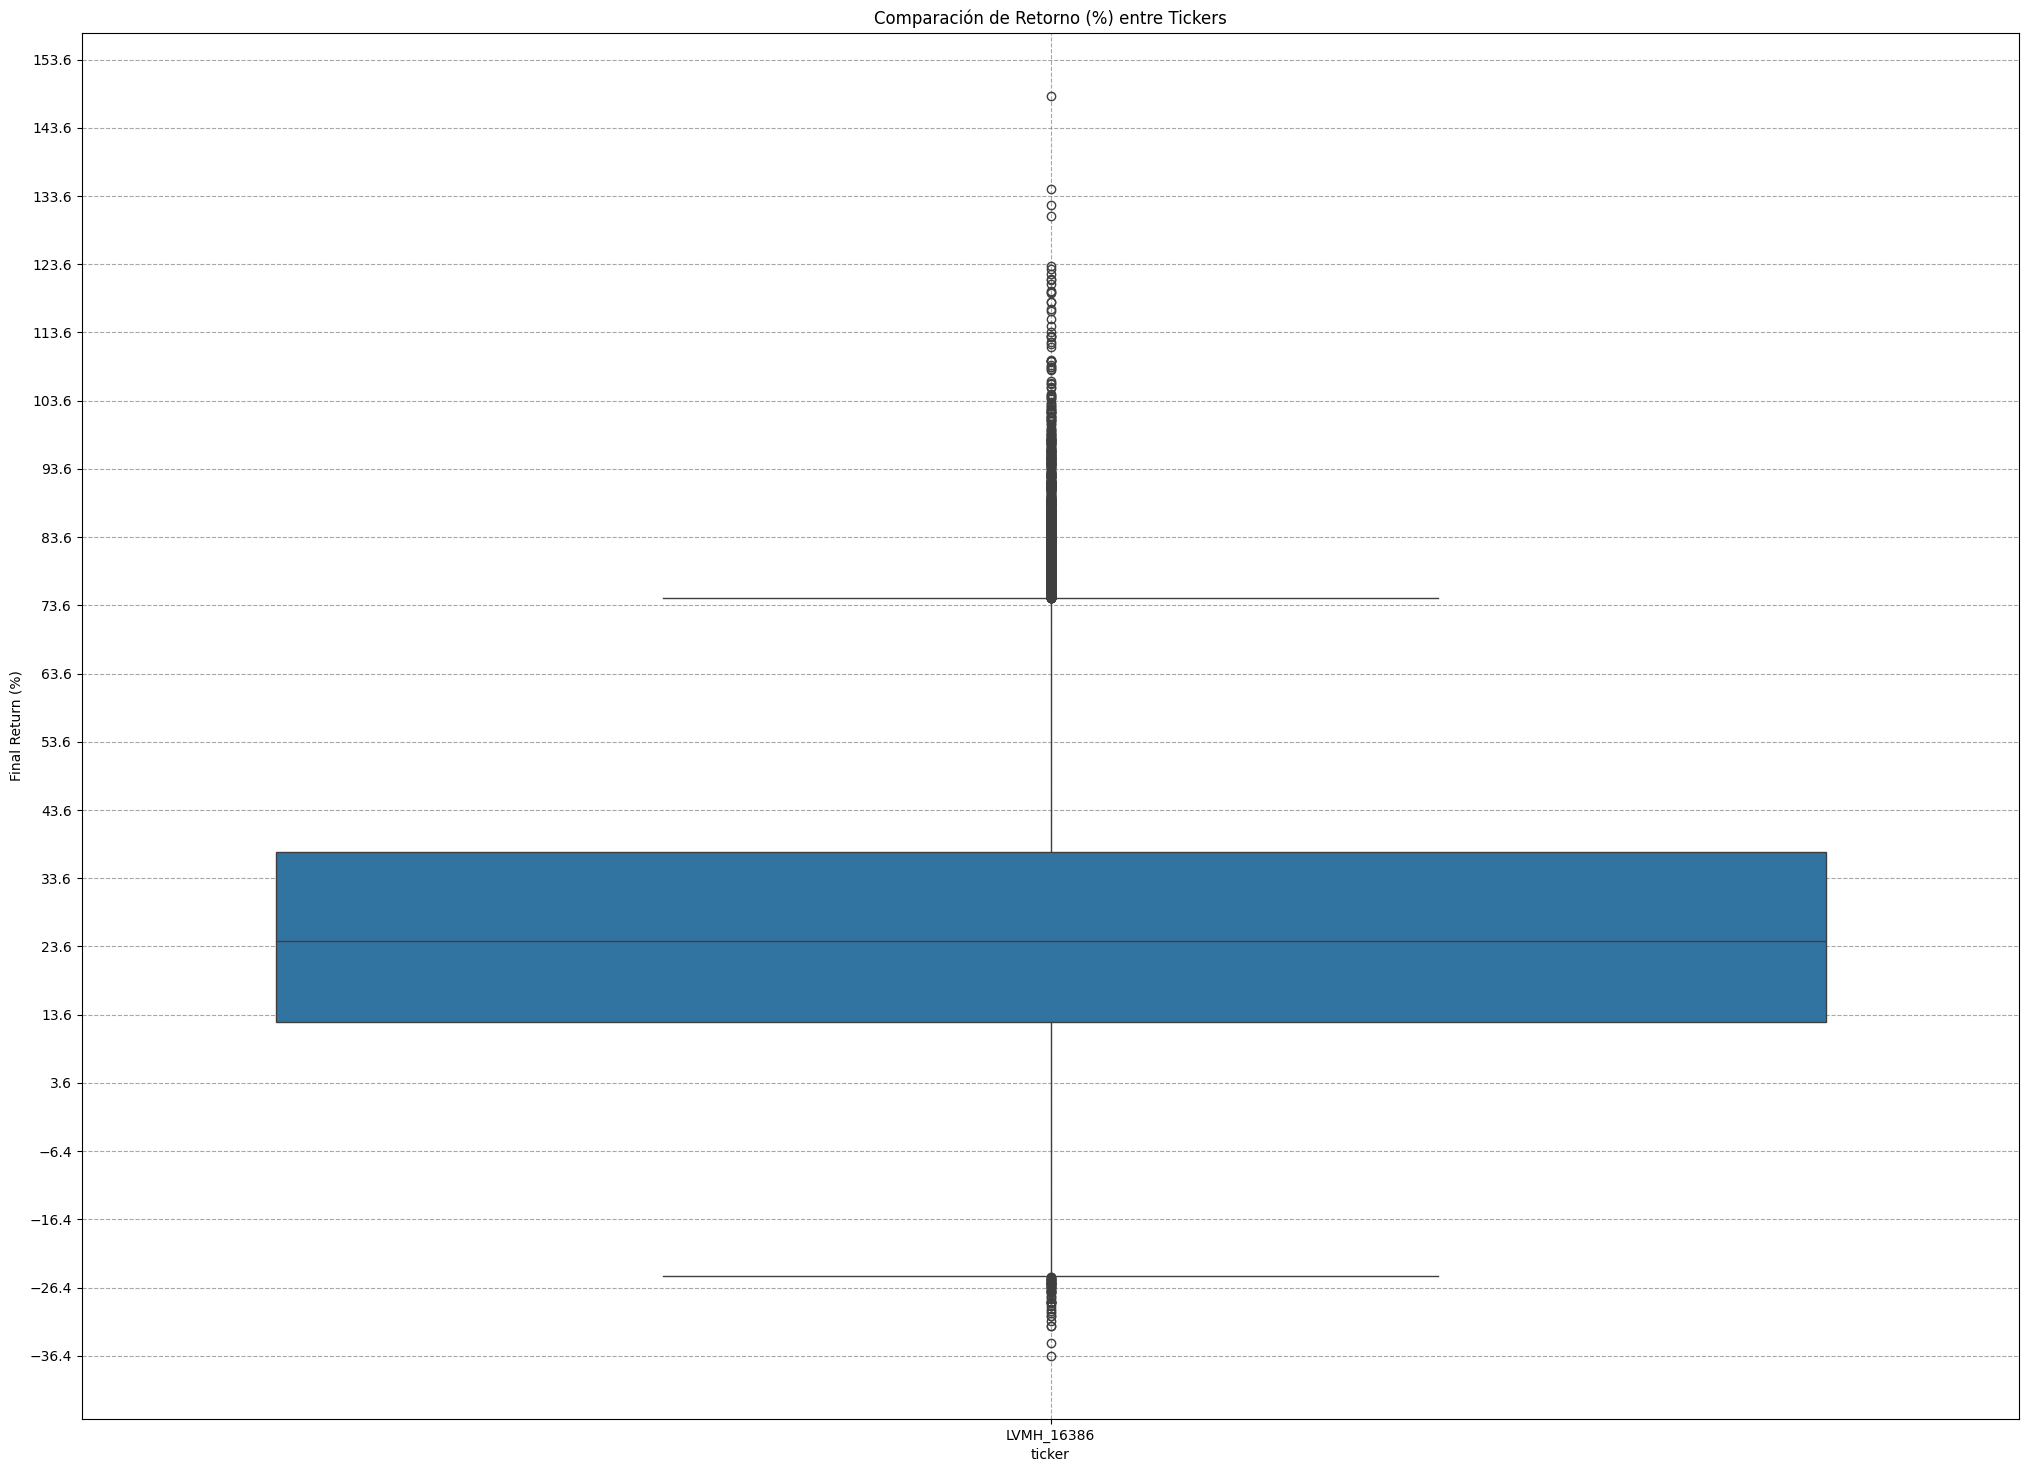

In [26]:
# Generar el gráfico
plt.figure(figsize=(25, 18))
sns.boxplot(data=all_returns, x="ticker", y="Final Return (%)")
plt.title("Comparación de Retorno (%) entre Tickers")

# Configurar ticks mayores con más números
y_max = all_returns["Final Return (%)"].max()  # Valor máximo en el eje Y
y_min = all_returns["Final Return (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 10  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()
